## Import & Data Load

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score



train = pd.read_csv('data//train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('data//test.csv').drop(columns=['SAMPLE_ID'])

In [2]:
# 데이터 확인
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


In [3]:
# 학습 데이터 데이터 타입, 데이터 개수, 칼럼명 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391938 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391938 non-null  float64
 10  DRAUGHT             391938 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391938 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  U_WIND              228251 non-nul

In [4]:
# 테스트 데이터 데이터 타입, 데이터 개수, 칼럼명 확인
test.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE
0,SG,GIW5,Container,1.826589,2020-06-18 11:58,K322654,50.0,18,117000,30.0,...,109000,340.0,KQMD74,Panama,0.37,1.63,27.1,1.587063,19,0.002615
1,CN,WEY7,Cargo,25.399386,2021-05-26 22:20,E376681,10.0,13,3810,10.0,...,2560,80.0,LBYS27,Belize,-2.79,-2.33,14.2,2.663972,6,0.001028
2,CN,NGG6,Container,111.079467,2019-12-16 0:09,F811111,20.0,26,10900,10.0,...,8440,140.0,EKFV15,Singapore,0.04,-4.91,9.3,3.255315,8,0.001743
3,CA,FFM2,Bulk,9.175258,2015-11-16 5:30,A737561,30.0,9,55800,20.0,...,31500,190.0,MASW32,Panama,NaN,NaN,NaN,NaN,2,0.000182
4,JP,QYY1,Container,0.000000,2018-10-24 1:11,A827175,30.0,19,39800,20.0,...,33000,220.0,SIEL54,Liberia,NaN,NaN,NaN,NaN,10,0.000552


In [5]:
# CI_HOUR칼럼이 대기시간이다. (test데이터에 해당 칼럼이 없는 이유)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220491 entries, 0 to 220490
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              220491 non-null  object 
 1   ARI_PO              220491 non-null  object 
 2   SHIP_TYPE_CATEGORY  220491 non-null  object 
 3   DIST                220491 non-null  float64
 4   ATA                 220491 non-null  object 
 5   ID                  220491 non-null  object 
 6   BREADTH             220491 non-null  float64
 7   BUILT               220491 non-null  int64  
 8   DEADWEIGHT          220491 non-null  int64  
 9   DEPTH               220491 non-null  float64
 10  DRAUGHT             220491 non-null  float64
 11  GT                  220491 non-null  int64  
 12  LENGTH              220491 non-null  float64
 13  SHIPMANAGER         220491 non-null  object 
 14  FLAG                220491 non-null  object 
 15  U_WIND              128766 non-nul

In [6]:
# 이상치 확인. 중복된 행 확인
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [7]:
# 결측치 확인
combined_df = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1)
combined_df.columns = ['Train', 'Test']
print(combined_df)

                     Train     Test
ARI_CO                   0      0.0
ARI_PO                   0      0.0
SHIP_TYPE_CATEGORY       0      0.0
DIST                     0      0.0
ATA                      0      0.0
ID                       0      0.0
BREADTH                  1      0.0
BUILT                    0      0.0
DEADWEIGHT               0      0.0
DEPTH                    1      0.0
DRAUGHT                  1      0.0
GT                       0      0.0
LENGTH                   1      0.0
SHIPMANAGER              0      0.0
FLAG                     0      0.0
U_WIND              163688  91725.0
V_WIND              163688  91725.0
AIR_TEMPERATURE     164630  92246.0
BN                  163688  91725.0
ATA_LT                   0      0.0
PORT_SIZE                0      0.0
CI_HOUR                  0      NaN


# 결측치, 이상치 확인 결과
+ U_WIND, V_WIND, AIR_TEMPERATURE, BN에 해당하는 칼럼에 데이터 결측치가 많았음.

In [8]:
train.describe()

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,391939.000000,391938.00000,391939.000000,391939.000000,391938.000000,391938.000000,391939.000000,391938.000000,228251.000000,228251.000000,227309.000000,228251.000000,391939.000000,391939.000000,391939.000000
mean,19.328187,30.55001,14.747989,63577.506780,16.476177,11.088106,41348.968666,205.121320,-0.294910,-0.263849,18.862968,2.706992,11.841580,0.000876,61.940835
std,30.930059,10.95707,7.043988,63515.531024,6.045930,4.599298,39304.543664,75.873891,3.366585,3.736949,9.729976,1.388026,6.644114,0.000838,170.809558
min,0.000000,10.00000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000,-21.450000,-32.200000,0.000000,0.000000,0.000005,0.000000
25%,0.000000,20.00000,10.000000,14300.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000,-2.280000,12.200000,1.805246,7.000000,0.000142,0.000000
50%,6.929678,30.00000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000,0.000000,21.600000,2.618063,12.000000,0.000552,7.944444
75%,25.692827,40.00000,18.000000,81500.000000,20.000000,10.000000,52100.000000,260.000000,1.540000,2.000000,26.600000,3.556236,17.000000,0.001614,49.176111
max,199.980651,60.00000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,0.002615,2159.130556


In [9]:
# 각 칼럼의 왜도 확인
train.skew(numeric_only=True)

DIST               2.482926
BREADTH            0.348941
BUILT              0.836319
DEADWEIGHT         1.571573
DEPTH             -0.029870
DRAUGHT            0.395419
GT                 1.498998
LENGTH             0.203090
U_WIND            -0.031121
V_WIND            -0.513227
AIR_TEMPERATURE   -0.782502
BN                 0.351398
ATA_LT            -0.067106
PORT_SIZE          0.865327
CI_HOUR            6.162590
dtype: float64

In [10]:
# 각 열의 왜도 계산
train.skew(numeric_only=True)

DIST               2.482926
BREADTH            0.348941
BUILT              0.836319
DEADWEIGHT         1.571573
DEPTH             -0.029870
DRAUGHT            0.395419
GT                 1.498998
LENGTH             0.203090
U_WIND            -0.031121
V_WIND            -0.513227
AIR_TEMPERATURE   -0.782502
BN                 0.351398
ATA_LT            -0.067106
PORT_SIZE          0.865327
CI_HOUR            6.162590
dtype: float64

In [11]:
# 각 칼럼의 첨도 확인
train.kurtosis(numeric_only=True)

DIST                6.959160
BREADTH             0.154824
BUILT               0.933388
DEADWEIGHT          2.557812
DEPTH              -0.294887
DRAUGHT             1.278828
GT                  2.271098
LENGTH             -0.508877
U_WIND              1.141962
V_WIND              1.624910
AIR_TEMPERATURE    -0.038454
BN                  0.410539
ATA_LT             -1.068353
PORT_SIZE          -0.495673
CI_HOUR            48.252184
dtype: float64

# 왜도, 첨도 관찰결과
+ train 데이터의  DIST칼럼의 첨도를 제외하면 특이사항 없음.

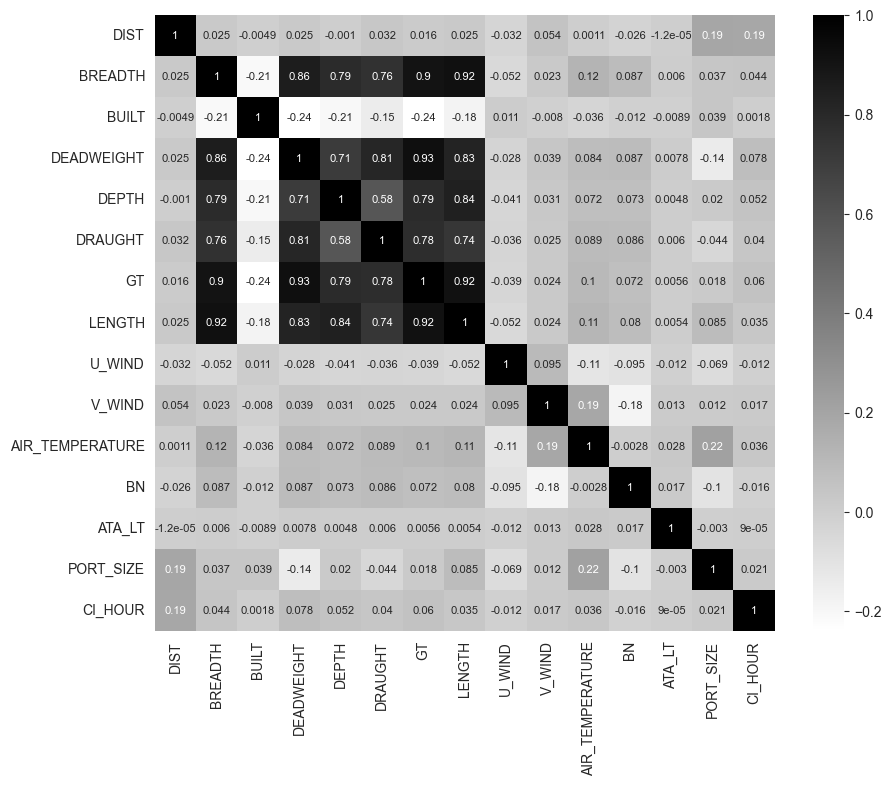

In [12]:
cmap = sns.color_palette("binary", as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap=cmap, annot_kws={"fontsize": 8})
plt.show()

# 변수간 상관관계 관찰 결과
+ 수치형 데이터만 상관관계를 분석
1. BREADTH, DEADWEIGHT, DEPTH, DRAUGHT, GT, LENGTH 변수들이 서로 상관관계가 강함
2. 해당 변수들은 선박의 크기와 관련 있음


## Data Pre-processing

# 전처리 과정 정리
## train, test데이터에 동시에 진행
1. 결측치 확인 후 평균값 대입
2. 선박의 크기를 대표하는 지표로 DEADWEIGHT(선박의 재화 중량 톤수)를 사용
3. 이상치가 많은 변수는 IQR 사분위수로 작업. IQR 경계값 넘은 이상치들 상한값과 하한값으로 치환
4. 'BN'변수인 보퍼트 풍력계급은 0~12로 이루어진 정수값. 실수값으로 되어있는 값은 반올림해서 정수형으로 치환
5. 'ATA'변수 각각 파생변수로 쪼갬.
6. 'ID' 선박 일련번호 필요없을거같아서 제거
7. 'U_WIND', 'V_WIND'는 풍향 데이터. 풍향데이터는 결측값이 많고 선박의 움직임에 더 많은 영향을 주는 요인을 풍력('BN')변수로 가정. 따라서 제거
8. 'SHIPMANAGER', 'FLAG' 같은 보조적인 변수 제거

In [13]:
# Data Pre-Processing
# train 및 test 데이터 복사
pre_processed_train = train.copy()
pre_processed_test = test.copy()

# datetime 컬럼 처리
pre_processed_train['ATA'] = pd.to_datetime(pre_processed_train['ATA'])
pre_processed_test['ATA'] = pd.to_datetime(pre_processed_test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [pre_processed_train, pre_processed_test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    pre_processed_train[feature] = le.fit_transform(pre_processed_train[feature].astype(str))
    le_classes_set = set(le.classes_)
    pre_processed_test[feature] = pre_processed_test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    pre_processed_test[feature] = le.transform(pre_processed_test[feature].astype(str))
    encoders[feature] = le

pre_processed_train.drop(columns=['ATA', 'ID', 'FLAG', 'SHIPMANAGER', 'U_WIND', 'V_WIND', 'BREADTH', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH'], inplace=True)
pre_processed_test.drop(columns=['ATA', 'ID', 'FLAG' ,'SHIPMANAGER', 'U_WIND', 'V_WIND', 'BREADTH', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH'], inplace=True)

# 결측치 처리
pre_processed_train.fillna(pre_processed_train.mean(), inplace=True)
pre_processed_test.fillna(pre_processed_train.mean(), inplace=True)

# 'BN' 보퍼트 풍력 계급 정수값으로 변경
pre_processed_train['BN'] = pre_processed_train['BN'].round().astype(int)
pre_processed_test['BN'] = pre_processed_test['BN'].round().astype(int)

for col in pre_processed_train.columns:
    if pre_processed_train[col].dtype != object:  # 숫자형 변수인 경우에만 처리
        q1 = np.percentile(pre_processed_train[col], 25)  # 1사분위수
        q3 = np.percentile(pre_processed_train[col], 75)  # 3사분위수
        iqr = q3 - q1                      # 사분위 범위 계산

        threshold_low = q1 - (1.5 * iqr)
        threshold_high = q3 + (1.5 * iqr)

        pre_processed_train[col] = np.clip(pre_processed_train[col], threshold_low, threshold_high)

for col in pre_processed_test.columns:
    if pre_processed_test[col].dtype != object:  # 숫자형 변수인 경우에만 처리
        q1 = np.percentile(pre_processed_test[col], 25)  # 1사분위수
        q3 = np.percentile(pre_processed_test[col], 75)  # 3사분위수
        iqr = q3 - q1                      # 사분위 범위 계산

        threshold_low = q1 - (1.5 * iqr)
        threshold_high = q3 + (1.5 * iqr)

        pre_processed_test[col] = np.clip(pre_processed_test[col], threshold_low, threshold_high)

# 전처리가 완료된 데이터를 CSV 파일로 저장
pre_processed_train.to_csv('data//pre_processed_train.csv', index=False)
pre_processed_test.to_csv('data//pre_processed_test.csv', index=False)


Encoding features: 100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


In [14]:
# 전처리 학습(train) 데이터 확인
pre_processed_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  int32  
 1   ARI_PO              391939 non-null  int32  
 2   SHIP_TYPE_CATEGORY  391939 non-null  int32  
 3   DIST                391939 non-null  float64
 4   BUILT               391939 non-null  int64  
 5   DEADWEIGHT          391939 non-null  int64  
 6   AIR_TEMPERATURE     391939 non-null  float64
 7   BN                  391939 non-null  float64
 8   ATA_LT              391939 non-null  int64  
 9   PORT_SIZE           391939 non-null  float64
 10  CI_HOUR             391939 non-null  float64
 11  year                391939 non-null  int32  
 12  month               391939 non-null  int32  
 13  day                 391939 non-null  int32  
 14  hour                391939 non-null  int32  
 15  minute              391939 non-nul

In [15]:
# 전처리 테스트(test) 데이터 확인
pre_processed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220491 entries, 0 to 220490
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              220491 non-null  int32  
 1   ARI_PO              220491 non-null  int32  
 2   SHIP_TYPE_CATEGORY  220491 non-null  int32  
 3   DIST                220491 non-null  float64
 4   BUILT               220491 non-null  int64  
 5   DEADWEIGHT          220491 non-null  int64  
 6   AIR_TEMPERATURE     220491 non-null  float64
 7   BN                  220491 non-null  float64
 8   ATA_LT              220491 non-null  int64  
 9   PORT_SIZE           220491 non-null  float64
 10  year                220491 non-null  int32  
 11  month               220491 non-null  int32  
 12  day                 220491 non-null  int32  
 13  hour                220491 non-null  int32  
 14  minute              220491 non-null  int32  
 15  weekday             220491 non-nul

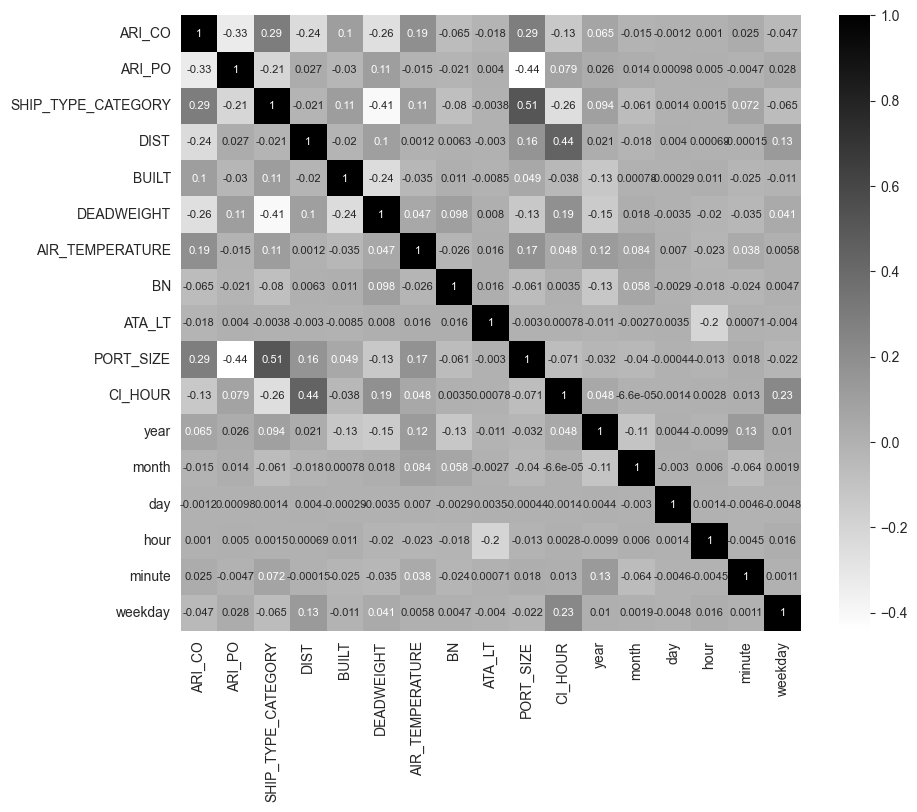

In [16]:
# 전처리 후 데이터 상관관계 분석
cmap = sns.color_palette("binary", as_cmap=True)
plt.figure(figsize=(10, 8))
sns.heatmap(pre_processed_train.corr(numeric_only=True), annot=True, cmap=cmap, annot_kws={"fontsize": 8})
plt.show()

# 다중공산성 분석

In [17]:
# "CI_HOUR"를 제외한 모든 칼럼 추출(독립변수)
independent_var = pre_processed_train.drop(columns=["CI_HOUR"])

In [18]:
# independent_variables는 독립 변수들의 데이터프레임

def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# VIF 계산
vif_data = calculate_vif(independent_var)

# VIF 값이 10 미만인 변수 선택
selected_columns = vif_data[vif_data["VIF"] < 10]["Variable"]

# 선택된 변수로 데이터프레임 업데이트
independent_var_selected = independent_var[selected_columns]
independent_var.info() # 다중공산성 판별 전 독립변수들
independent_var_selected.info() # 다중공산성 판별 후 독립변수들
# 16개의 칼럼에서 13개의 칼럼으로 줄어듬.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  int32  
 1   ARI_PO              391939 non-null  int32  
 2   SHIP_TYPE_CATEGORY  391939 non-null  int32  
 3   DIST                391939 non-null  float64
 4   BUILT               391939 non-null  int64  
 5   DEADWEIGHT          391939 non-null  int64  
 6   AIR_TEMPERATURE     391939 non-null  float64
 7   BN                  391939 non-null  float64
 8   ATA_LT              391939 non-null  int64  
 9   PORT_SIZE           391939 non-null  float64
 10  year                391939 non-null  int32  
 11  month               391939 non-null  int32  
 12  day                 391939 non-null  int32  
 13  hour                391939 non-null  int32  
 14  minute              391939 non-null  int32  
 15  weekday             391939 non-nul

# PCA

In [19]:
# PCA에 앞서 데이터 스케일 정규화
# StandardScaler를 생성
scaler = StandardScaler()

# 독립변수 데이터를 표준화
independent_var_selected_scaled = scaler.fit_transform(independent_var_selected)

In [20]:
# PCA 모델 생성 (주성분 수 지정)
pca = PCA(n_components=2)

# PCA 모델을 사용하여 데이터 변환
X_pca = pca.fit_transform(independent_var_selected_scaled)

# df_pca는 2개의 주성분으로 구성된 새로운 독립변수 df
df_pca = pd.DataFrame(data=X_pca, columns=["C1", "C2"])

df_pca

,C1,C2
0,2.795479,-0.055149
1,-1.205494,-1.416829
2,0.462615,0.536888
3,-0.206796,-1.135626
4,1.779049,2.592393
...,...,...
391934,0.672084,-1.781922
391935,1.687231,0.120784
391936,-0.542813,0.609945
391937,2.017926,-0.865459


C:\Users\user\Desktop\portTerminalTimeDelay prediction\venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\Desktop\portTerminalTimeDelay prediction\venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\Desktop\portTerminalTimeDelay prediction\venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\Desktop\portTerminalTimeDelay prediction\venv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\Desktop\portTerminalTimeDelay prediction\venv\Lib\site-packages\I

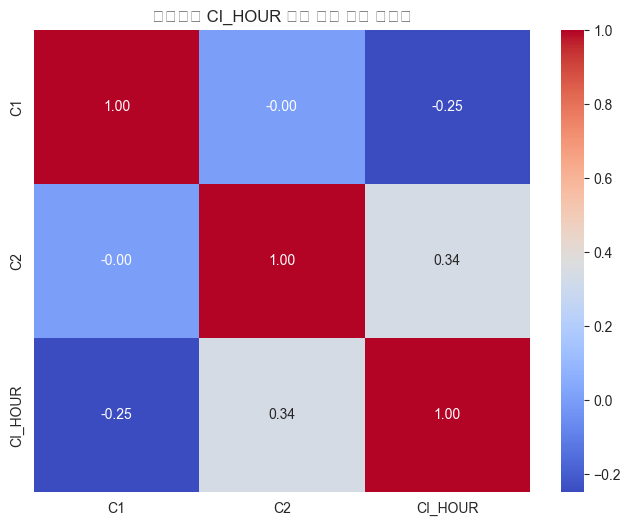

In [21]:
# 주성분 1, 2 및 "CI_HOUR"를 추출하여 하나의 데이터프레임 만들기
data = pd.concat([df_pca[['C1', 'C2']], pre_processed_train['CI_HOUR']], axis=1)

# 상관 관계 행렬 계산
correlation_matrix = data.corr()

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('주성분과 CI_HOUR 간의 상관 관계 히트맵')
plt.show()


In [22]:
df_pca

,C1,C2
0,2.795479,-0.055149
1,-1.205494,-1.416829
2,0.462615,0.536888
3,-0.206796,-1.135626
4,1.779049,2.592393
...,...,...
391934,0.672084,-1.781922
391935,1.687231,0.120784
391936,-0.542813,0.609945
391937,2.017926,-0.865459


## 모델 학습 및 특성 중요도 확인
+ 학습 모델은 선형회귀, 다항회귀, 다중선형회귀를 사용
+ case 1. 전처리 후 데이터 사용.
    + 3가지 회귀 중 3차 다항회귀가 가장 성능이 뛰어났음
    + Polynomial Regression - MSE: 1021.6095659308066, R-squared: 0.4590609220422731
+ case 2. 전처리, 다중공산성 체크한 데이터 사용
    + 3가지 회귀 중 2차 다항회귀가 가장 성능이 뛰어났음
    + Polynomial Regression - MSE: 1121.820185277229, R-squared: 0.4059997117339723
+ case 3. 전처리, 다중공산성, PCA분석한 데이터 사용
    + 3가지 회귀가 성능이 거의 비슷했음
    + Polynomial Regression - MSE: 1507.5123701519283, R-squared: 0.20177690311967633

In [23]:
# 독립 변수와 종속 변수 분리
X = pre_processed_train.drop(columns='CI_HOUR')  # 독립 변수 선택
y = pre_processed_train['CI_HOUR']  # 종속 변수 선택

# 데이터 분할 (학습 데이터와 테스트 데이터로)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# 다항 회귀 모델
poly_degree = 3  # 다항 차수 선택
poly_features = PolynomialFeatures(degree=poly_degree)
X_poly = poly_features.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)
X_test_poly = poly_features.transform(X_test)
y_pred_poly = poly_model.predict(X_test_poly)

# 다중 선형 회귀 모델
multi_linear_model = LinearRegression()
multi_linear_model.fit(X_train, y_train)
y_pred_multi_linear = multi_linear_model.predict(X_test)

# 각 모델의 성능 평가
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)
print(f"Linear Regression - MSE: {linear_mse}, R-squared: {linear_r2}")

poly_mse = mean_squared_error(y_test, y_pred_poly)
poly_r2 = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression - MSE: {poly_mse}, R-squared: {poly_r2}")

multi_linear_mse = mean_squared_error(y_test, y_pred_multi_linear)
multi_linear_r2 = r2_score(y_test, y_pred_multi_linear)
print(f"Multiple Linear Regression - MSE: {multi_linear_mse}, R-squared: {multi_linear_r2}")

Linear Regression - MSE: 1334.3891168494788, R-squared: 0.29344512563592073
Polynomial Regression - MSE: 1021.6095659308066, R-squared: 0.4590609220422731
Multiple Linear Regression - MSE: 1334.3891168494788, R-squared: 0.29344512563592073


In [24]:
# 독립 변수와 종속 변수 분리
X = independent_var_selected  # 독립 변수 선택
y = pre_processed_train['CI_HOUR']  # 종속 변수 선택

# 데이터 분할 (학습 데이터와 테스트 데이터로)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# 다항 회귀 모델
poly_degree = 2  # 다항 차수 선택
poly_features = PolynomialFeatures(degree=poly_degree)
X_poly = poly_features.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)
X_test_poly = poly_features.transform(X_test)
y_pred_poly = poly_model.predict(X_test_poly)

# 다중 선형 회귀 모델
multi_linear_model = LinearRegression()
multi_linear_model.fit(X_train, y_train)
y_pred_multi_linear = multi_linear_model.predict(X_test)

# 각 모델의 성능 평가
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)
print(f"Linear Regression - MSE: {linear_mse}, R-squared: {linear_r2}")

poly_mse = mean_squared_error(y_test, y_pred_poly)
poly_r2 = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression - MSE: {poly_mse}, R-squared: {poly_r2}")

multi_linear_mse = mean_squared_error(y_test, y_pred_multi_linear)
multi_linear_r2 = r2_score(y_test, y_pred_multi_linear)
print(f"Multiple Linear Regression - MSE: {multi_linear_mse}, R-squared: {multi_linear_r2}")

Linear Regression - MSE: 1346.151606112841, R-squared: 0.2872169242674132
Polynomial Regression - MSE: 1121.820185277229, R-squared: 0.4059997117339723
Multiple Linear Regression - MSE: 1346.151606112841, R-squared: 0.2872169242674132


In [25]:
# 독립 변수와 종속 변수 분리
X = df_pca  # 독립 변수 선택
y = pre_processed_train['CI_HOUR']  # 종속 변수 선택

# 데이터 분할 (학습 데이터와 테스트 데이터로)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# 다항 회귀 모델
poly_degree = 2  # 다항 차수 선택
poly_features = PolynomialFeatures(degree=poly_degree)
X_poly = poly_features.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)
X_test_poly = poly_features.transform(X_test)
y_pred_poly = poly_model.predict(X_test_poly)

# 다중 선형 회귀 모델
multi_linear_model = LinearRegression()
multi_linear_model.fit(X_train, y_train)
y_pred_multi_linear = multi_linear_model.predict(X_test)

# 각 모델의 성능 평가
linear_mse = mean_squared_error(y_test, y_pred_linear)
linear_r2 = r2_score(y_test, y_pred_linear)
print(f"Linear Regression - MSE: {linear_mse}, R-squared: {linear_r2}")

poly_mse = mean_squared_error(y_test, y_pred_poly)
poly_r2 = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression - MSE: {poly_mse}, R-squared: {poly_r2}")

multi_linear_mse = mean_squared_error(y_test, y_pred_multi_linear)
multi_linear_r2 = r2_score(y_test, y_pred_multi_linear)
print(f"Multiple Linear Regression - MSE: {multi_linear_mse}, R-squared: {multi_linear_r2}")

Linear Regression - MSE: 1554.537313041025, R-squared: 0.1768773425676311
Polynomial Regression - MSE: 1507.510252741978, R-squared: 0.20177802428163916
Multiple Linear Regression - MSE: 1554.537313041025, R-squared: 0.1768773425676311


# 회귀 결과가 잘 안나와서 랜덤 포레스트로 모델링
+ 랜덤서치로 모델 튜닝

In [26]:
# 독립 변수와 종속 변수 분리
X = pre_processed_train.drop(columns="CI_HOUR")  # 독립 변수 선택
y = pre_processed_train['CI_HOUR']  # 종속 변수 선택

# 데이터 분할 (학습 데이터와 테스트 데이터로)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델
rf_model = RandomForestRegressor()

# 탐색할 하이퍼파라미터 범위 설정
param_dist = {
    "n_estimators": [10, 50, 100],  # 나무의 수
    "max_depth": [None, 10, 20, 30],  # 나무의 깊이
    "min_samples_split": [2, 5, 10],  # 노드 분할을 위한 최소 샘플 수
    "min_samples_leaf": [1, 2, 4],  # 리프 노드에 필요한 최소 샘플 수
    "max_features": ["auto", "sqrt", "log2"],  # 분할할 때 고려할 특성의 수
}

# 랜덤 서치를 사용한 모델 튜닝
random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=30, cv=5, n_jobs=-1, verbose=2
)
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 조합
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# 튜닝된 모델
tuned_rf_model = random_search.best_estimator_

# 모델 평가
y_pred_rf_tuned = tuned_rf_model.predict(X_test)
rf_tuned_mse = mean_squared_error(y_test, y_pred_rf_tuned)
rf_tuned_r2 = r2_score(y_test, y_pred_rf_tuned)
print(f"Random Forest Regression (Tuned) - MSE: {rf_tuned_mse}, R-squared: {rf_tuned_r2}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits


C:\Users\user\Desktop\portTerminalTimeDelay prediction\venv\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
55 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\Desktop\portTerminalTimeDelay prediction\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\Desktop\portTerminalTimeDelay prediction\venv\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\user\Desktop\portTerminalTimeDelay prediction\venv\Lib\site-pac

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30}
Random Forest Regression (Tuned) - MSE: 770.5355977967733, R-squared: 0.592003804872337


# 테스트 데이터셋의 대기시간 예측 후 저장

In [27]:
# 이전에 튜닝한 최적의 랜덤 포레스트 모델
tuned_rf_model = RandomForestRegressor(
    n_estimators=100,  # 예시로 설정된 하이퍼파라미터
    min_samples_split=5,  # 예시로 설정된 하이퍼파라미터
    min_samples_leaf=2,  # 예시로 설정된 하이퍼파라미터
    max_features='log2',  # 예시로 설정된 하이퍼파라미터
    max_depth=None  # 예시로 설정된 하이퍼파라미터
)

# 학습 데이터로 모델 학습
tuned_rf_model.fit(X_train, y_train)  # 여기서 X_train, y_train은 학습 데이터와 해당 데이터의 대기시간

X = pre_processed_test # test 데이터셋

# 테스트 데이터로 예측
y_pred_test = tuned_rf_model.predict(X)

# 테스트 데이터 예측값 확인
pred_CI_HOUR = pd.DataFrame(y_pred_test, columns=['CI_HOUR'])


In [28]:
pred_CI_HOUR

,CI_HOUR
0,41.265550
1,38.468911
2,57.006649
3,64.437459
4,0.000000
...,...
220486,68.796555
220487,54.072873
220488,44.364489
220489,0.454487
